In [1]:
from datasets import load_dataset
from mango.utils.tokenization import retain_cyrillic

cv13 = load_dataset('mozilla-foundation/common_voice_13_0', 'uk', trust_remote_code=True)
urban = load_dataset('danavery/urbansound8K')

urban = urban['train'].rename_column('class', 'label')
cv13 = cv13['train'].rename_columns({'sentence': 'transcription', 'client_id': 'speaker_id'})
cv13 = retain_cyrillic(cv13, 'transcription')

cv13.set_format('pt')
urban.set_format('pt')

In [5]:
import torch
from mango.training.DatasetMixer import DatasetMixer, DatasetMixerConfig
from tqdm.auto import tqdm


class InMemoryDataset(torch.utils.data.Dataset):
    def __init__(self, mixer: DatasetMixer):
        self.mixer = mixer
        self.len = mixer.config.utterances_count
        self.examples = [mixer.generate() for _ in tqdm(range(self.len))]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.examples[idx]


mixer = DatasetMixer(
    DatasetMixerConfig(max_speakers=3, utterances_count=250, beta=5, min_repetitions=3, max_repetitions=6), cv13,
    urban)
evaluation_data = InMemoryDataset(mixer)

  0%|          | 0/250 [00:00<?, ?it/s]

In [6]:
from mango.diarization import EENDDiarizer, EENDConfig

diarizer = EENDDiarizer(EENDConfig(hf_api_model_path='anakib1/eend-sa',
                                   run_id='run-24-02-06.20-17',
                                   hf_api_model_name='model.pt',
                                   hf_api_processor_path='openai/whisper-small',
                                   max_num_speakers=3))

In [7]:
predictions = []
labels = []
for i in tqdm(range(len(evaluation_data))):
    predictions.append(diarizer.diarize(evaluation_data[i].audio))
    labels.append(evaluation_data[i].diarization)

  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\bsvja\PycharmProjects\MangoDemo\mango\diarization.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waveform = torchaudio.transforms.Resample(sr, 16_000)(torch.tensor(waveform, dtype=torch.float))


In [11]:
from mango.utils.diarization import calculate_diarization_accuracy
import numpy as np

calculate_diarization_accuracy(preds=np.stack(predictions), labels=np.stack(labels))

{'speech_scored': 227274,
 'speech_miss': 0,
 'speech_falarm': 147726,
 'speaker_miss': 0,
 'speaker_falarm': 817892,
 'speaker_error': 0,
 'speaker_correct': 204.73866271972656,
 'diarization_error': 817892,
 'frames': 250,
 'speaker_wide_frames': 307108,
 'speech_scored_ratio': 909.096,
 'speech_miss_ratio': 0.0,
 'speech_falarm_ratio': 590.904,
 'speaker_correct_ratio': 0.8189546508789063,
 'speaker_miss_ratio': 0.0,
 'speaker_falarm_ratio': 2.6632064290086874,
 'speaker_error_ratio': 0.0,
 'diarization_error_ratio': 2.6632064290086874}

In [27]:
from mango.utils.diarization import draw_diarization

example_score = []
for i in range(250):
    try :
        example_score.append(calculate_diarization_accuracy(labels[i], predictions[i])['diarization_error_ratio'])
    except Exception as ex:
        example_score.append(np.nan)

<Axes: >

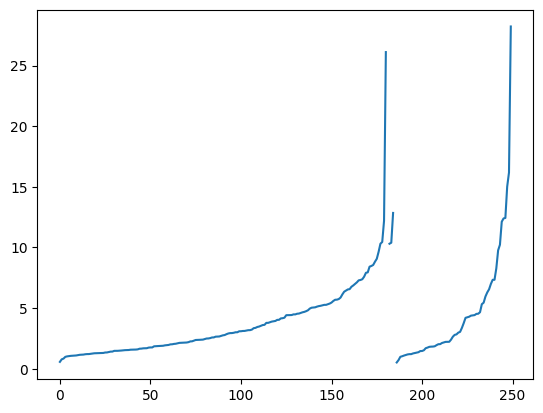

In [44]:
import pandas as pd 
pd.Series(sorted(example_score)).plot()

In [33]:
np.argsort(example_score)[::-1]

array([145,  70,  38,  58, 165, 170, 111, 222, 238,  49, 221, 126, 114,
        50, 116, 244, 215, 132, 143, 150, 181, 188, 130, 209,  65, 134,
        28, 138, 228, 231,  34,   2, 149,  73, 213,  94,  29,  40, 236,
        82,  51,  69, 246,  15, 204,  16,  74,  78,  67,  83,  35, 248,
        53, 120, 203,   3,  77,  46,  32, 162,  54, 110, 100,  64,  48,
        25,   4,  63, 205, 187,  92, 160, 102, 198, 242,  37,  20,  86,
       249,  39,  68,  56, 235, 220, 240, 227,  52, 232, 179,   1,  76,
        87, 146,  31,   6,  43, 183, 107, 206,  21, 129,  71,  59, 166,
       139, 224,  10, 153,  66,  14, 119, 118,  11,   0, 117, 234, 158,
        97, 226,  60,  89,  79, 157,  85, 216, 195, 106, 182, 167,  91,
        42,  30, 194,  62,  99, 184, 151, 115, 147, 124, 245, 169,  61,
       164, 175, 168, 159, 108, 229, 190, 191, 163, 207, 177, 137, 112,
        96, 128, 223,  41,  24, 142, 214, 199,  44,  45,  13, 225, 180,
        57, 178,  47, 122, 103, 133, 247,  19, 192, 208, 193, 18

In [39]:
from IPython.display import Audio
Audio(evaluation_data[49].audio,rate=16_000)

{'speech_scored': 830, 'speech_miss': 0, 'speech_falarm': 670, 'speaker_miss': 0, 'speaker_falarm': 3670, 'speaker_error': 0, 'speaker_correct': 276.6666564941406, 'diarization_error': 3670, 'frames': 1500, 'speaker_wide_frames': 830, 'speech_scored_ratio': 0.5533333333333333, 'speech_miss_ratio': 0.0, 'speech_falarm_ratio': 0.44666666666666666, 'speaker_correct_ratio': 0.18444443766276042, 'speaker_miss_ratio': 0.0, 'speaker_falarm_ratio': 4.421686746987952, 'speaker_error_ratio': 0.0, 'diarization_error_ratio': 4.421686746987952}


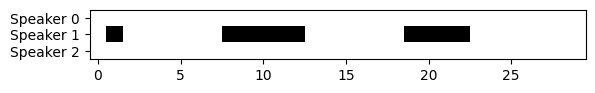

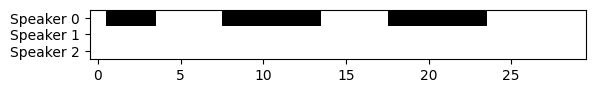

In [61]:
def describe_pair(index: int):
    draw_diarization(predictions[index])
    draw_diarization(labels[index])
    Audio(evaluation_data[i].audio, rate=16_000)
    print(calculate_diarization_accuracy(labels[i], predictions[i]))
    
describe_pair(162)

In [31]:


Audio(evaluation_data[70].audio, rate=16_000)

C:\Users\bsvja\anaconda3\envs\pythonProject\lib\site-packages\IPython\lib\display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767
C:\Users\bsvja\anaconda3\envs\pythonProject\lib\site-packages\IPython\lib\display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan
